# Packing Kilosort / phy outputs using pynwb

[Kilosort](https://github.com/cortex-lab/KiloSort) is a Matlab-based spike-sorting package optimized for large, high-density electrode arrays such as [Neuropixels](https://www.nature.com/articles/nature24636). It takes continuous electrophysiological traces as input, and outputs spike times and associated unit IDs for each. The results typically require some amount of manual post-processing, which can be carried out in [phy](https://github.com/kwikteam/phy), a graphical application written in Python. Phy allows the user to refine the output of Kilosort by merging and splitting units, and to tag each unit with a label, such as "good" or "noise."

This notebook documents the steps involved in converting the output of Kilosort/phy into a pynwb file. It uses Python 2.7, but most steps should also be compatible with Python 3.

In [1]:
# General imports

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pynwb imports

from pynwb import NWBFile, NWBHDF5IO
from pynwb.ecephys import Clustering, ClusterWaveforms
from pynwb.misc import UnitTimes

In [3]:
# Designate path to files

datapath = r"/Users/Josh/Data/mouse366119/probeE/experiment2/recording2/continuous/Neuropix-110.0/"

In [4]:
# Load the data

# phy .npy outputs:
amplitudes = np.load(os.path.join(datapath, 'amplitudes.npy'))
channel_positions = np.load(os.path.join(datapath, 'channel_positions.npy'))
spike_clusters = np.load(os.path.join(datapath, 'spike_clusters.npy'))
spike_times = np.load(os.path.join(datapath, 'spike_times.npy'))

# non-standard .npy file containing mean waveforms for each cluster:
mean_waveforms = np.load(os.path.join(datapath, 'mean_waveforms.npy'))

# tsv file containing cluster labels:
cluster_groups = pd.read_csv(os.path.join(datapath, 'cluster_group.tsv'), '\t')

# manually specify sampling rate in Hz
# If the data came from Open Ephys, the sampling rate is available in the 'structure.oebin' json file
# for example:
#    import json
#    info = json.load(open(fname))
#    sampling_rate = float(info['continuous'][0]['sample_rate'])
sampling_rate = 30000.

Now, let's take a look at the data...

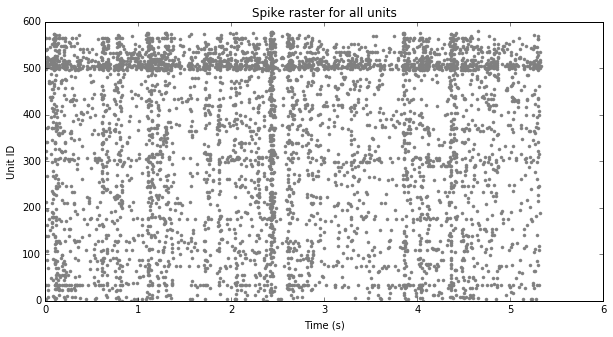

In [38]:
plt.figure(figsize=(10,5))

plt.plot(spike_times[:5000]/sampling_rate,
         spike_clusters[:5000],
         '.', color='gray')

plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
plt.title('Spike raster for all units')
plt.show()

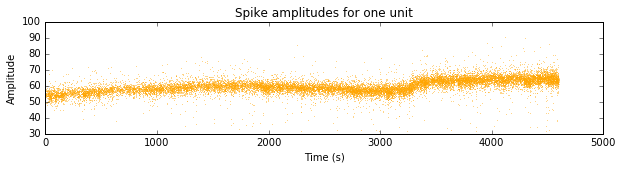

In [42]:
plt.figure(figsize=(10,2))

unitID = 537

plt.plot(spike_times[spike_clusters == unitID]/sampling_rate,
         amplitudes[spike_clusters == unitID],
         '.', color='orange',
         markersize=1,
         alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Spike amplitudes for one unit')

plt.show()

(584, 82, 384)


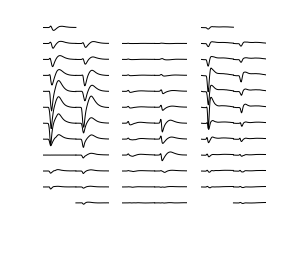

In [84]:
# mean_waveforms dimensions:
#   unit ID
#   time sample
#   channel
print(mean_waveforms.shape)

plt.figure(figsize=(4,4))

unitIDs = [537, 517, 520]

for index, unitID in enumerate(unitIDs):

    plt.subplot(1,len(unitIDs),index+1)
    
    waveform = mean_waveforms[unitID,:,:]
    peak_channel = np.argmax(np.max(waveform,0)-np.min(waveform,0))

    for ch in range(peak_channel-11,peak_channel+11):
        wv = waveform[:,ch]
        x = np.linspace(0,1,wv.size) + channel_positions[ch,0]
        y = np.ones(wv.shape) + channel_positions[ch,1]*1000
        plt.plot(x, waveform[:,ch]+y,'k')
    
    plt.axis('off')

plt.show()

#### Time to start packaging...

In [5]:
# First, we create the file

nwbfile = NWBFile('NWB 1.0 > NWB 1.2 converter',      # source
                  'session_description',              # session description
                  'identifier',                       # identifier
                  datetime.datetime.now(),               # date
                  experimenter = 'experimenter',      # experimenter
                  lab = 'Ephys Ops',                  # lab
                  institution ='Allen Institute',     # institution
                  experiment_description = 'experiment_description',   # experiment description
                  session_id = 'SESSION_ID')

In [6]:
# add a module for spikes

module = nwbfile.create_processing_module('ecephys', # name
                                       'ecephys', #source
                                        'Clustering module' # description
                                      )

In [104]:
# clustering interface

clustering = Clustering('probe', # source
                       'Kilosort outputs', # description
                       spike_clusters, # cluster ID
                       amplitudes, #(not quite) peak over RMS
                       spike_times / sampling_rate, # times in s
                       'clustering') # name

module.add_data_interface(clustering)  

In [ ]:
# waveform interface

waveforms = ClusterWaveforms(source, 
                             clustering, # clustering interface 
                             '300 to 3000 Hz bandpass',  #waveform filtering
                             waveform_mean, 
                             waveform_sd, 
                             name='ClusterWaveforms')

module.add_data_interface(waveforms)  

In [7]:
# UnitTimes interface

unit_times = UnitTimes('source')

for index, unitID in enumerate(cluster_groups['cluster_id'].values):
    
    if cluster_groups['group'].iloc[unitID] == 'good':
        times = spike_times[spike_clusters == unitID]
        unit_times.add_spike_times(unitID, times)

module.add_data_interface(unit_times)  

In [8]:
# save the file

io = NWBHDF5IO('example2.nwb', 'w')
io.write(nwbfile)
io.close()

In [9]:
# read it back in

io = NWBHDF5IO('example2.nwb')
nwbfile = io.read()

In [93]:
nwbfile